In [3]:
COLAB = False
base_path = '../'
if COLAB:
    !pip install diffusers accelerate python_dotenv huggingface_hub
    !mkdir _res
    base_path = '/content/'

In [5]:
from diffusers import AutoencoderKL
from accelerate import Accelerator
from _utils import *
from dotenv import load_dotenv
import os
from huggingface_hub import HfApi

load_dotenv()
HUG = os.getenv('HUG')
api = HfApi()

DIFF_MODEL = "CompVis/stable-diffusion-v1-4"
dtype=torch.float32
data_path = f'{base_path}data/fern/'
save_path = f'{base_path}_res/'
model_path = f'{save_path}model/'
H = 512
W = 392
INIT = False
TRAIN = True
NERF = True
SCALE = False
ONLY = True

In [6]:
if NERF:
    nf = NerfDataset(data_path, save_path, SCALE, ONLY)
    dataset = nf
else:
    dataset = ImageDataset(data_path, dtype, H, W)
    
vae = AutoencoderKL.from_pretrained(DIFF_MODEL,subfolder="vae", torch_dtype=dtype).to('cuda')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
dataloader = DataLoader(dataset, batch_size=1)

accelerator = Accelerator()
vae, optimizer, dataloader = accelerator.prepare(vae, optimizer, dataloader)

if INIT:
    vae.apply(initialize_weights)

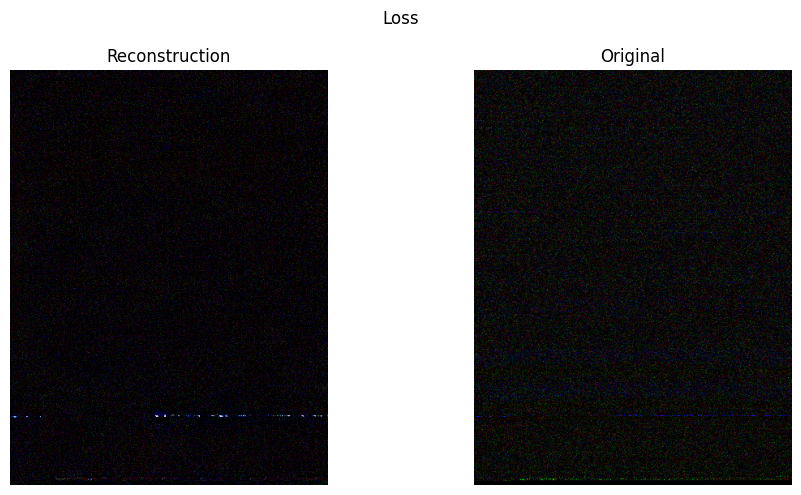

KeyboardInterrupt: 

In [7]:
if TRAIN:
    vae.train()
    num_epochs = 500
    for epoch in range(num_epochs):
        bi = 0
        for batch in dataloader:
            bi += 1
            optimizer.zero_grad()
            with accelerator.autocast():
                data_rec = vae(batch).sample
                is_plt = False
                if epoch%50 == 0:
                  is_plt = True
                loss = compare_img('Loss', data_rec, batch, criterion, is_plt)
                accelerator.backward(loss)
                optimizer.step()
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch[{bi}/{len(dataloader)}] Loss: {loss.item()}")
            print('Recon')
            
            del data_rec, loss
            torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    if NERF:
        enc3_recs = vae(nf.npy).sample
        res = nf.decode(enc3_recs)
        uns_org = nf.enc3_1['uns_org']
        uns_rec = res[0]['uns_rec']
        loss = compare_img('No scale', uns_org, uns_rec, criterion)
        print(loss)
        # compare_img(res[1]['rec_uns'], nf.enc3_2['org_uns'], criterion)
        if SCALE:
            scl_org = nf.enc3_1['scl_org']
            scl_rec = res[0]['scl_rec']
            loss = compare_img('Scale', scl_org, scl_rec, criterion)
            print(loss)
            # compare_img(res[1]['rec_scl'], nf.enc3_2['org_scl'], criterion)

    else:
        img_org = make_image(data_path, dtype, H, W)
        img_rec = vae(img_org).sample
        compare_img(img_org, img_rec, criterion)

In [12]:
nf.save_dec_npy(res)

save to ../_res/model_200000.npy
save to ../_res/model_fine_200000.npy


In [11]:
vae.save_pretrained(model_path)

api.upload_folder(
    folder_path=model_path,
    path_in_repo="ck/1",
    repo_id="dinleo11/SD-NeRF",
    repo_type="model",
    token=HUG
)

CommitInfo(commit_url='https://huggingface.co/dinleo11/SD-NeRF/commit/921ba06afd2b2a71e0021720d173e65467d5e92a', commit_message='Upload folder using huggingface_hub', commit_description='', oid='921ba06afd2b2a71e0021720d173e65467d5e92a', pr_url=None, pr_revision=None, pr_num=None)